The SDK provides '[rooftop](https://solcast.com/rooftop-pv-power-model)' and '[advanced](https://solcast.com/advanced-pv-power-model)' PV power estimates.  The advanced estimates use a more sophisticated PV model with comprehensive and flexible site configuration options.  Advanced PV power estimates are available for the [`live`](https://solcast.github.io/solcast-api-python-sdk/live/) and [`forecast`](https://solcast.github.io/solcast-api-python-sdk/forecast/) modules.  They require that a PV Power Site has been set up in the Solcast API to specify the configuration.  Site configurations can be managed via the [`pv_power_sites`](https://solcast.github.io/solcast-api-python-sdk/pv_power_sites/) module.   Calls to functions in this module do not consume any of your API request quota.

In this example, we will use the SDK to

* obtain some forecast PV power estimates for an existing site
* create a new PV Power Site configuration
* obtain some live PV power estimates for the site
* modify the site configuration
* modify the PV model settings

In [74]:
import pandas as pd

from solcast import live, forecast, pv_power_sites

## Get Data at an Existing Site

You can list the PV Power Sites available to you.  These include test sites at Solcast's [unmetered locations](https://docs.solcast.com.au/#unmetered-locations), as well as any sites you have set up for yourself.  For instance, you can list the available PV Power Sites and find the test site at the Giza Pyramid Complex.

In [17]:
res = pv_power_sites.list_pv_power_sites()
[s for s in res.to_dict() if s["name"] == 'Test Site: Giza Pyramid Complex']

[{'resource_id': '8d10-f530-af85-5cbb',
  'name': 'Test Site: Giza Pyramid Complex',
  'latitude': 29.977296,
  'longitude': 31.132496,
  'capacity': 145,
  'capacity_dc': 180,
  'azimuth': 180,
  'tilt': 27.28,
  'tracking_type': 'horizontal_single_axis',
  'install_date': '2021-07-01T00:00:00.0000000Z',
  'module_type': 'poly-si',
  'ground_coverage_ratio': 0.36,
  'derating_temp_module': 0.0039,
  'derating_age_system': 0.0059,
  'derating_other_system': 0.0221,
  'inverter_peak_efficiency': 0.985,
  'tracker_axis_azimuth': 0,
  'tracker_max_rotation_angle': 60,
  'tracker_back_tracking': True,
  'tracker_smart_tracking': False,
  'terrain_slope': 0,
  'terrain_azimuth': 0,
  'dust_soiling_average': [0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015,
   0.015],
  'bifacial_system': False,
  'site_ground_albedo': 0.25,
  'bifaciality_factor': 0.7,
  'pvrow_height': 1.5,
  'pvrow_width': 2,
  'is_unmetered': True,
  'confirmed_me

Note that the site configuration has a unique `resource_id`, in this case '8d10-f530-af85-5cbb'. We need to use this to access data modelled using this site's configuration, which is for a 145 kW capacity tracking array.

<Axes: xlabel='period_end'>

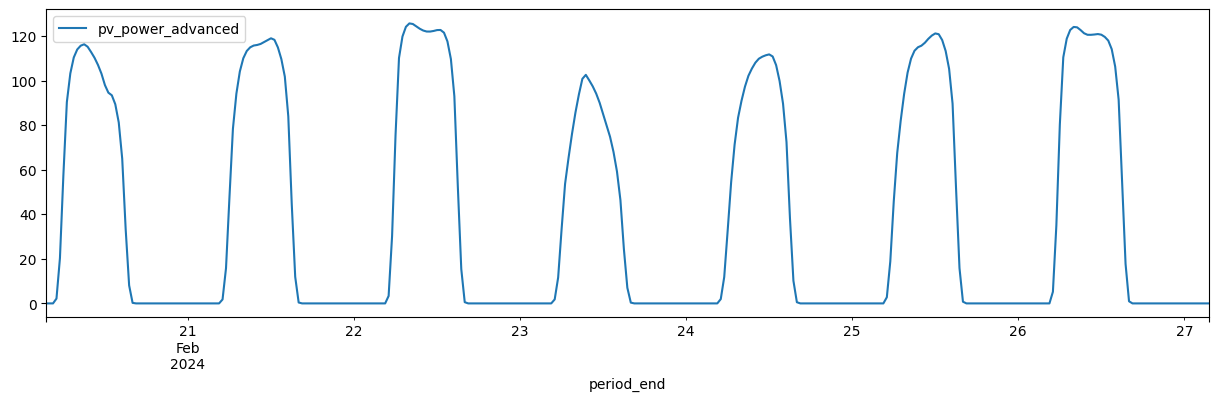

In [3]:
# This will not consume an API request, as as it an unmetered test site.
res = forecast.advanced_pv_power("8d10-f530-af85-5cbb")
res.to_pandas().plot(figsize=[15, 4])

## Create a Site

We will now show how to make your own site configuration, so that we can changes to the metadata.  Initially we specify a minimal set of parameters for a PV plant with trackers and 1MW AC capacity.  Defaults are used for other parameters.

In [62]:
lat, lon = 35.978120, -118.339086

res = pv_power_sites.create_pv_power_site(
    latitude=lat,
    longitude=lon,
    name="my test site",
    capacity=1000,
    capacity_dc=1200,
    tracking_type='horizontal_single_axis',
    install_date="2024-02-13",
)
metadata = res.to_dict()
metadata

{'resource_id': '94af-4847-f15c-4dee',
 'name': 'my test site',
 'latitude': 35.97812,
 'longitude': -118.339086,
 'capacity': 1000,
 'capacity_dc': 1200,
 'tracking_type': 'horizontal_single_axis',
 'install_date': '2024-02-13T00:00:00.0000000Z',
 'module_type': 'poly-si',
 'ground_coverage_ratio': 0.36,
 'derating_temp_module': 0.0039,
 'derating_age_system': 0.0059,
 'derating_other_system': 0.0175,
 'inverter_peak_efficiency': 0.985,
 'tracker_axis_azimuth': 0,
 'tracker_max_rotation_angle': 60,
 'tracker_back_tracking': True,
 'tracker_smart_tracking': False,
 'terrain_slope': 0,
 'terrain_azimuth': 0,
 'dust_soiling_average': [0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015],
 'bifacial_system': False,
 'site_ground_albedo': 0.25,
 'bifaciality_factor': 0.7,
 'pvrow_height': 1.5,
 'pvrow_width': 2,
 'is_unmetered': False}

## Power Timeseries and Adjusting the Site's Metadata

We can use the `resource_id` to obtain a timeseries of PV power modelled based on the specifications of the site.  For instance, the following will give estimates for the last 7 days.

<Axes: xlabel='period_end'>

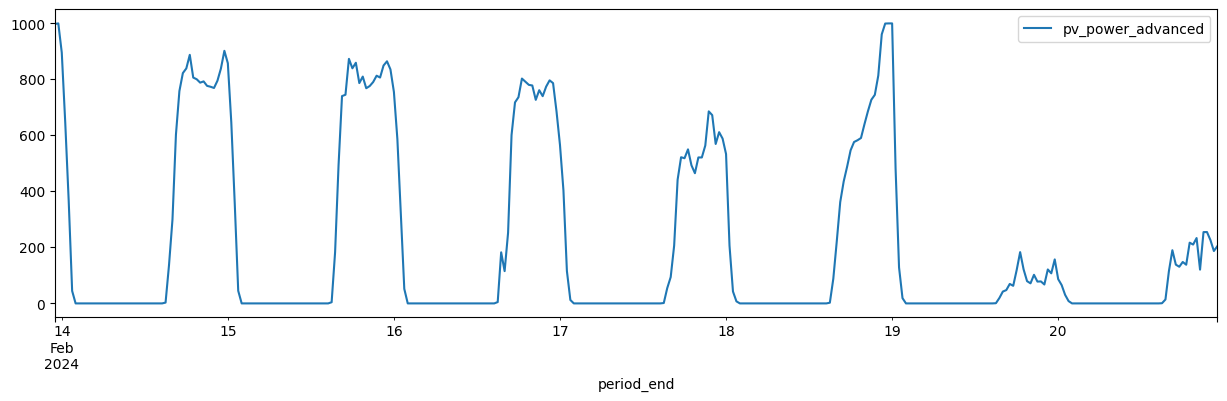

In [63]:
resource_id = metadata["resource_id"]
timeseries = {}

# NOTE: this will consume an API request!
res = live.advanced_pv_power(resource_id)
timeseries["initial"] = res.to_pandas()
timeseries["initial"].plot(figsize=[15, 4])

We can adjust metadata to our site using `pv_power_sites.patch_pv_power_site`.  You can see definitions of the various available parameters in the [API documentation](https://docs.solcast.com.au/#ba412164-31c2-47a9-a965-c95bc9b632a6).  Let's say we know our site has bifacial panels and that the tracker axis is oriented 10 degrees from north towards the east.  We can adjust the site's settings accordingly.

In [67]:
res = pv_power_sites.patch_pv_power_site(
    resource_id=resource_id,
    bifacial_system=False,
    tracker_axis_azimuth=-10,
)
res.to_dict()

{'resource_id': '94af-4847-f15c-4dee',
 'name': 'my test site',
 'latitude': 35.97812,
 'longitude': -118.339086,
 'capacity': 1000,
 'capacity_dc': 1200,
 'tracking_type': 'horizontal_single_axis',
 'install_date': '2024-02-13T00:00:00.0000000Z',
 'module_type': 'poly-si',
 'ground_coverage_ratio': 0.36,
 'derating_temp_module': 0.0039,
 'derating_age_system': 0.0059,
 'derating_other_system': 0.0175,
 'inverter_peak_efficiency': 0.985,
 'tracker_axis_azimuth': -10,
 'tracker_max_rotation_angle': 60,
 'tracker_back_tracking': True,
 'tracker_smart_tracking': False,
 'terrain_slope': 0,
 'terrain_azimuth': 0,
 'dust_soiling_average': [0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015,
  0.015],
 'bifacial_system': False,
 'site_ground_albedo': 0.25,
 'bifaciality_factor': 0.7,
 'pvrow_height': 1.5,
 'pvrow_width': 2,
 'is_unmetered': False,
 'confirmed_metadata': '2024-02-20T23:01:38.9434961Z'}

<Axes: xlabel='period_end'>

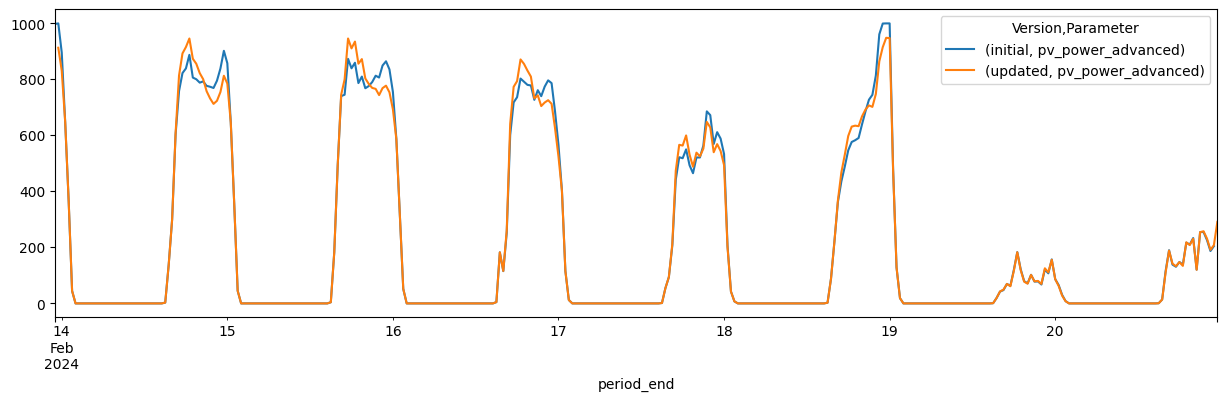

In [68]:
# NOTE: this will consume an API request!
res = live.advanced_pv_power(resource_id)
timeseries["updated"] = res.to_pandas()
pd.concat(
    timeseries.values(),
    keys=timeseries.keys(),
    axis="columns",
    names=["Version", "Parameter"]
).plot(figsize=[15, 4])

## Adjusting Advanced PV Power Settings

When comparing observed production to Solcast live PV estimates, if you find discrepancies you may be able to choose more appropriate [model settings](https://docs.solcast.com.au/?#0c9d3ccf-e2a4-4583-86a3-f89c8d658fde) to get estimates which better fit the observations.  We will give a couple of examples.

### Snow Soiling

In the example shown here, say our observed production reached 640 kW on the last day.  It turns out that there was snow at this location in the last few days, and the PV model by default applies a snow soiling adjustment in these conditions.  However, we know that we have kept the snow off our panels.  By turning off the snow soiling in the PV model as follows, we get estimates which now match our observed peak production.

<Axes: xlabel='period_end'>

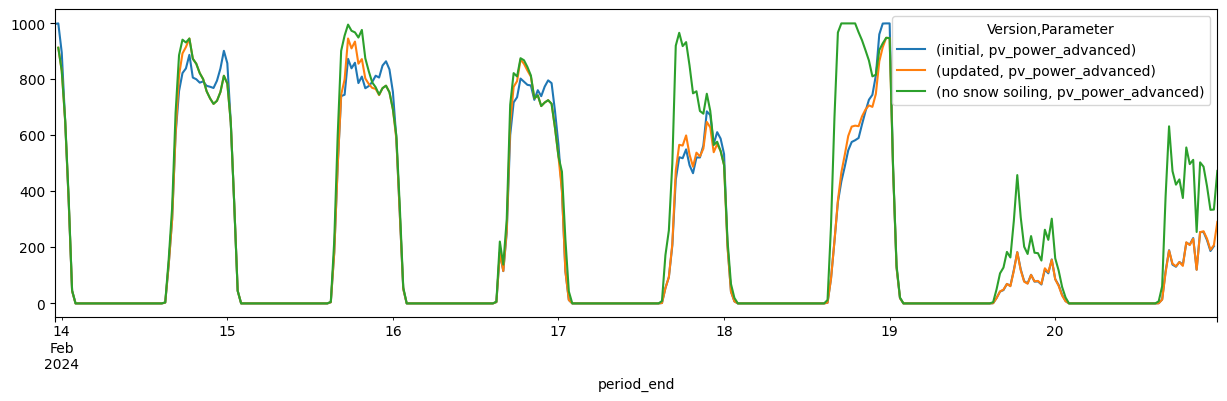

In [69]:
# NOTE: this will consume an API request!
res = live.advanced_pv_power(resource_id, apply_snow_soiling=0)
timeseries["no snow soiling"] = res.to_pandas()
pd.concat(
    timeseries.values(),
    keys=timeseries.keys(),
    axis="columns",
    names=["Version", "Parameter"]
).plot(figsize=[15, 4])

### Terrain Shading

The PV model can apply terrain shading based on a 90m resolution model of the terrain, but this is not applied by default.  We have located our solar plant in a location which experiences late afternoon shading, so the Solcast PV power is overestimating the generation in the late afternoon.  We can include the terrain shading via the advanced PV power settings as follows.

<Axes: xlabel='period_end'>

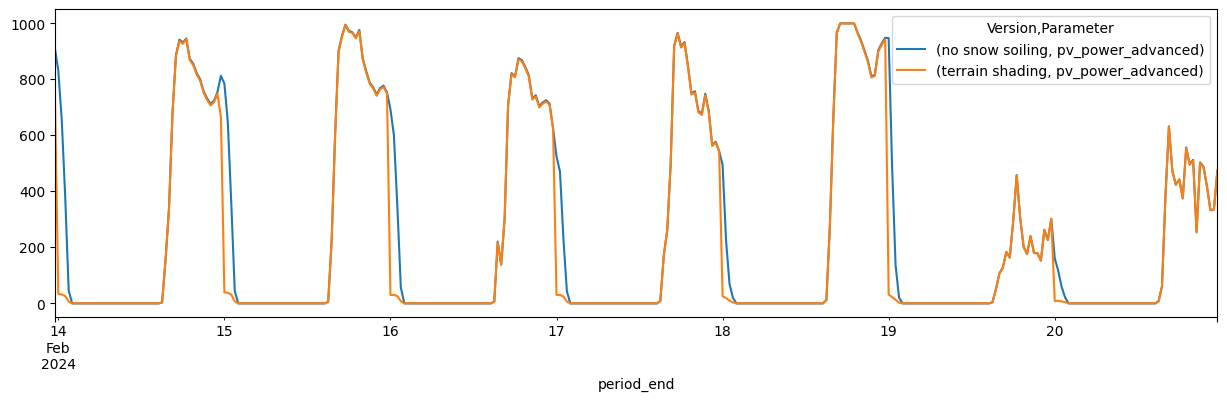

In [70]:
# NOTE: this will consume an API request!
res = live.advanced_pv_power(resource_id, apply_snow_soiling=0, terrain_shading=True)
timeseries["terrain shading"] = res.to_pandas()
to_plot = ["no snow soiling", "terrain shading"]
pd.concat(
    [timeseries[n] for n in to_plot],
    keys=to_plot,
    axis="columns",
    names=["Version", "Parameter"]
).plot(figsize=[15, 4])

## Direct Comparison to Measurements

If you have a timeseries of near real-time measurements, you can use these for comparison with the pv_power_advanced estimates and to assist with adusting PV model settings or checking and fine-tuning PV Site configuration.  When using measurements, it is important to correctly time-align the data and perform quality control where possible.  These example notebooks suggest some approaches for irradiance, many of which are applicable to PV power as well:
* [3.1 Comparing to Measurements: Timezone and Time Period alignment](https://solcast.github.io/solcast-api-python-sdk/notebooks/3.1%20Comparing%20to%20Measurements%20-%20Timezone%20and%20Time%20Period%20alignment/)
* [3.2 Comparing to Measurements [GHI]: Quality Controlling and Gap Filling Measurements with Solcast Actuals](https://solcast.github.io/solcast-api-python-sdk/notebooks/3.2%20Comparing%20to%20Measurements%20%5BGHI%5D%20-%20Quality%20Controlling%20and%20Gap%20Filling%20Measurements%20with%20Solcast%20Actuals/)

An additional factor for PV power is curtailment of generation, where the maximum output of the PV plant is capped for a period due to market regulations.  The PV model does not include the effect of curtailment, so periods where the measurements are curtailed should be excluded from comparisons.
